In [12]:
import pandas as pd
import numpy as np
from arch import arch_model
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [13]:
cpi_df = pd.read_csv('CPIAUCSL.csv')
unrate_df = pd.read_csv('UNRATE.csv')

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])
unrate_df['DATE'] = pd.to_datetime(unrate_df['DATE'])

merged_df = pd.merge(cpi_df, unrate_df, on='DATE', how='inner')

merged_df['CPI_RATE'] = merged_df['CPIAUCSL'].pct_change() * 100
merged_df = merged_df.dropna()

In [14]:
def identify_outliers_zscore(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    return df[np.abs((df[column] - mean) / std) > threshold].index

cpi_outliers = identify_outliers_zscore(merged_df, 'CPI_RATE')
unrate_outliers = identify_outliers_zscore(merged_df, 'UNRATE')

merged_df.loc[cpi_outliers, 'CPI_RATE'] = np.nan
merged_df.loc[unrate_outliers, 'UNRATE'] = np.nan

merged_df['CPI_RATE'] = merged_df['CPI_RATE'].interpolate()
merged_df['UNRATE'] = merged_df['UNRATE'].interpolate()

In [15]:
cpi_rate = merged_df['CPI_RATE']

# fit the ARMA(1,1)-GARCH(1,1) model
# ARMA(1,1) for the mean, GARCH(1,1) for the variance
arma_garch_model = arch_model(cpi_rate, vol='Garch', p=1, q=1, mean='AR', lags=1)
model_fit = arma_garch_model.fit(disp='off')

print("ARMA(1,1)-GARCH(1,1) Model Summary:")
print(model_fit.summary())

ARMA(1,1)-GARCH(1,1) Model Summary:
                           AR - GARCH Model Results                           
Dep. Variable:               CPI_RATE   R-squared:                       0.383
Mean Model:                        AR   Adj. R-squared:                  0.382
Vol Model:                      GARCH   Log-Likelihood:                84.0653
Distribution:                  Normal   AIC:                          -158.131
Method:            Maximum Likelihood   BIC:                          -134.025
                                        No. Observations:                  917
Date:                Sat, Nov 02 2024   Df Residuals:                      915
Time:                        02:15:44   Df Model:                            2
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------------------
Const           0.1094  1

c:\Users\jakub\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [16]:
significant_params = model_fit.pvalues[model_fit.pvalues < 0.05]
if len(significant_params) > 0:
    print("\nSignificant coefficients (p < 0.05):")
    print(significant_params)
else:
    print("\nNo significant coefficients at the 5% level.")


Significant coefficients (p < 0.05):
Const          3.684511e-25
CPI_RATE[1]    4.409706e-40
alpha[1]       1.982322e-02
beta[1]        8.217310e-29
Name: pvalues, dtype: float64


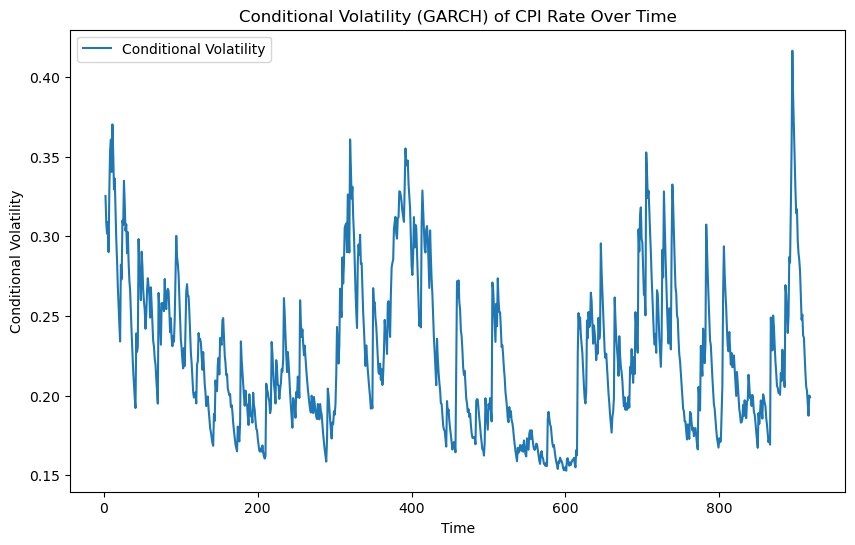

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model_fit.conditional_volatility, label="Conditional Volatility")
ax.set_title("Conditional Volatility (GARCH) of CPI Rate Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Conditional Volatility")
ax.legend()
plt.show()